In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import tqdm
from torch.distributions import MultivariateNormal
from torch.distributions import mixture_same_family
import seaborn as sns


/net/galaxy/home/koes/rishal/.conda/envs/nce/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
#arguments

nll_loss_multiplier=1
score_loss_multiplier=1

In [4]:
class SwishBeta(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

In [5]:
class MLPplus(nn.Module):
    def __init__(self, dim=256,time_scale=1):
        super().__init__()
        self.time_scale=time_scale
        self.dim=dim
        self.input = nn.Sequential(
            nn.Linear(3, self.dim,bias=True),  # Increased hidden size
            SwishBeta(1.0),
            
        )
        
        # Encoder 
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.dim, self.dim,bias=True),  
                SwishBeta(1.0),
            ) for i in range(3)  
        ])
        

        
        # Decoder 
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.dim, self.dim,bias=True),
                SwishBeta(1.0)
            ) for _ in range(3)  #  Residual Blocks
        ])
        self.output = nn.Linear(self.dim, 1, bias=True)


    def forward(self, x,t):
        with torch.set_grad_enabled(True):
            # Concatenate input and time embedding
            x_initial=torch.cat((x,t),1)
            x = self.input(x_initial) 
            #logz= self.time_mlp(x_initial[:,-1].unsqueeze(1))*(2*np.sqrt(2)-1)*self.time_scale
            # Pass through encoder with residual connections
            for layer in self.encoder:
                x = layer(x) + x
            
            # Pass through decoder with residual connections
            for layer in self.decoder:
                x = layer(x) + x
            
            # Final output layer
            potential = self.output(x)
            #log_prob=log_unnormalized-logz
            return potential

In [6]:
class InterpolantModel:
    def __init__(self, dim=256,lr=1e-3,score_loss_multiplier=1e-4,nll_loss_multiplier=1,OT=False,integration_method='dopri5',interpolant_type='trig',antithetic=False):
        self.OT=OT
        self.model = MLPplus(dim)
        
        self.samples=None
        self.score_loss_multiplier=score_loss_multiplier
        self.nce_loss_multiplier=nll_loss_multiplier
        self.dim=dim
        self.antithetic=antithetic
        self.interpolant_type=interpolant_type
        self.interpolant_type='trig'
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.integration_method=integration_method
    def log_pt(self,x,t):
        if t.dim()==0:
            t=t*torch.ones(x.shape[0],1).to(x.device)
        if t.shape[0]!=x.shape[0]:
            t=t.unsqueeze(0).repeat(x.shape[0],1)
        potential = self.model(x,t)
        potential=potential.view(-1,1)
        return potential
    
    def alpha(self,t):
        if self.interpolant_type=='linear':
            return 1-t
        elif self.interpolant_type=='trig':
            return torch.cos(t*torch.pi/2)
        else:
            raise ValueError('interpolant type not supported')
    
    def sigma(self,t):
        if self.interpolant_type=='linear':
            return t
        elif self.interpolant_type=='trig':
            return torch.sin(t*torch.pi/2)
        else:
            raise ValueError('interpolant type not supported')

    def sigma_dot(self,t):
        if self.interpolant_type=='linear':
            return torch.ones_like(t)
        elif self.interpolant_type=='trig':
            return (torch.pi/2)*torch.cos(t*torch.pi/2)
        else:
            raise ValueError('interpolant type not supported')
    
    def alpha_dot(self,t):
        if self.interpolant_type=='linear':
            return -torch.ones_like(t)
        elif self.interpolant_type=='trig':
            return -(torch.pi/2)*torch.sin(t*torch.pi/2)
        else:
            raise ValueError('interpolant type not supported')
    
    def score(self,x,t):
        with torch.set_grad_enabled(True):
            x.requires_grad=True
            t.requires_grad=True
            potential = self.log_pt(x,t)
            grad_x,grad_t=torch.autograd.grad(potential.sum(),[x,t],create_graph=True,retain_graph=True)
            return grad_x,grad_t,potential    
    
    
    def train_step(self, x, num_steps=1000):
        lossVmse=[]
        lossTmse=[]
        lossNLL=[]
        for _ in range(num_steps):
            self.optimizer.zero_grad()
            
            # Sample timesteps
            
            if self.antithetic:
                t=torch.rand((int(x.shape[0]/2))).to(x.device)
                t=torch.cat((t,t),dim=0)
                t=t * 0.999 + 0.001
                t=t.view(-1,1)
            else:
                t = torch.rand((x.shape[0],)).to(x.device)
                t=t.view(-1,1)
            

            #sample noise
            noise=torch.randn_like(x)
            if self.antithetic:
                noise=torch.randn((int(x.shape[0]/2),2))
                noise=torch.cat((noise,-noise),dim=0).to(x.device)

            #obtain xt
            alpha_t=self.alpha(t)
            alpha_t=alpha_t.view(-1,1)
            sigma_t=self.sigma(t)
            sigma_t=sigma_t.view(-1,1)
            alpha_t_dot=self.alpha_dot(t)
            alpha_t_dot=alpha_t_dot.view(-1,1)
            sigma_t_dot=self.sigma_dot(t)
            sigma_t_dot=sigma_t_dot.view(-1,1)
            

            xt=alpha_t*x + sigma_t*noise
            
            #predicted scores and log_probs
            score_x,score_t,ll=self.score(xt,t)

            #score matching loss
            if self.antithetic:
                lossposMSE=torch.mean((score_x + noise/sigma_t)**2)
            else:
                lossposMSE=torch.mean((sigma_t*score_x + noise)**2)

            #sample negatives
            t_negatives=torch.rand((x.shape[0],1)).to(x.device)
            ll_negatives=self.log_pt(xt,t_negatives)
            ll_negatives=ll_negatives.view(-1,1)
            
            nce_loss=-torch.mean(ll-torch.logsumexp(torch.cat([ll_negatives.unsqueeze(1),ll.unsqueeze(1)],dim=1),dim=1))
        
            #loss=lossposMSE + self.time_score_multiplier*losstimeMSE + self.nll_loss_multiplier*nll_loss
            loss=self.score_loss_multiplier*lossposMSE + self.nce_loss_multiplier*nce_loss
            #loss=lossposMSE
            
            loss.backward()
            
            #lossTmse.append(losstimeMSE.detach().cpu().numpy())
            #lossNLL.append(nll_loss.detach().cpu().numpy())
            
            
            self.optimizer.step()
        return lossposMSE.item(),nce_loss.item()

    @torch.no_grad()
    def log_prob(self,x):
        t=torch.zeros(x.shape[0],1).to(x.device)
        log_prob=self.log_pt(x,t)
        return log_prob
    
   
        

In [7]:
def generate_gaussians_on_circle(n_samples=10000, n_gaussians=8, radius=1.0, std_dev=0.1):

    # Compute angles of Gaussian centers
    gaussian_angles = np.linspace(0, 2 * np.pi, n_gaussians, endpoint=False)
    gaussian_means=torch.tensor([[radius*np.cos(angle), radius*np.sin(angle)] for angle in gaussian_angles],dtype=torch.float32)
    gaussian_means=gaussian_means.to('cuda')

    #make gaussians mixture
    gaussian_mixture = mixture_same_family.MixtureSameFamily(
        mixture_distribution=mixture_same_family.Categorical(torch.ones(n_gaussians).to('cuda')),
        component_distribution=MultivariateNormal(gaussian_means,(std_dev**2)*torch.eye(2).to('cuda'))
    )
    data=gaussian_mixture.sample((n_samples,))

    return data, gaussian_mixture

In [8]:
def normalize_data(data):
    mean = data.mean(dim=0, keepdim=True)
    std = data.std(dim=0, keepdim=True)
    std = torch.clamp(std, min=1e-8)  
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

In [9]:
def generate_checkerboard(n_samples=2000, xy_range=1.0, grid_width=0.4):
 
    data = []
    

    while len(data) < n_samples:

        point = np.random.uniform(-xy_range, xy_range, (2,))
        
        x_idx = int(point[0] // grid_width)
        y_idx = int(point[1] // grid_width)
        
    
        if (x_idx + y_idx) % 2 == 0:
            data.append(point)
    data_np = np.array(data)
    return torch.tensor(data_np, dtype=torch.float32)

In [10]:
def checkerboard_logprob(x,xy_range=1.0,grid_width=0.4):
    log_prob = torch.zeros(x.shape[0])
    for i in range(x.shape[0]):
        x_idx = int(x[i, 0] // grid_width)
        y_idx = int(x[i, 1] // grid_width)
        if torch.abs(x[i,0])<xy_range and torch.abs(x[i,1])< xy_range and (x_idx + y_idx) % 2 == 0:
            log_prob[i] = 0
        else:
            log_prob[i] = -1000 #very large negative value
    return log_prob

In [11]:
data,gaussian_mixture = generate_gaussians_on_circle()
#data=generate_checkerboard(n_samples=10000)
interpolant = InterpolantModel(lr=1e-3,score_loss_multiplier=score_loss_multiplier,nll_loss_multiplier=nll_loss_multiplier,OT=False,integration_method='dopri5',interpolant_type='linear',antithetic=False)
data=data.cuda()
interpolant.model=interpolant.model.cuda()

In [12]:

posslosses=[]
ncelosses=[]
batch_size=10000
for epoch in tqdm.tqdm(range(10000)):
    for i in range(0,data.shape[0],batch_size):
        data_batch=data[i:i+batch_size]
        poss_loss,nce_loss=interpolant.train_step(data_batch, num_steps=1)
        posslosses.append(poss_loss)
        ncelosses.append(nce_loss)

100%|██████████| 10000/10000 [01:57<00:00, 85.00it/s]


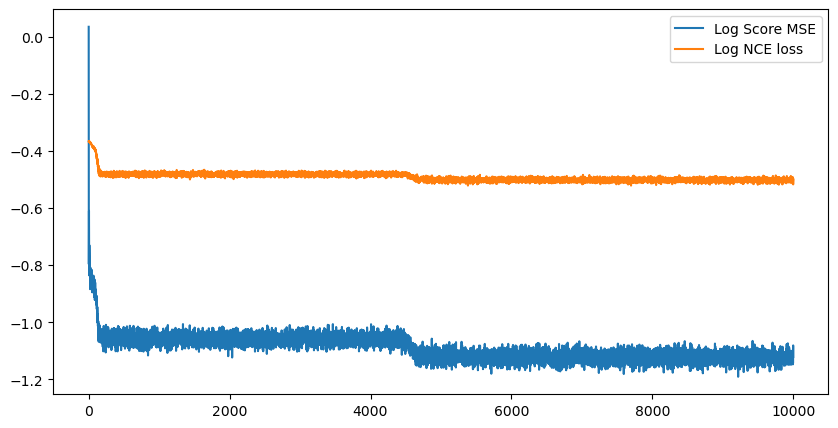

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(posslosses),label='Log Score MSE')
plt.plot(np.log(ncelosses),label='Log NCE loss')
plt.legend()

In [14]:
x = torch.linspace(-2,2,100).cuda()
u = torch.cartesian_prod(x, x.__reversed__()).cuda()

In [15]:
log_prob_data=gaussian_mixture.log_prob(u).cpu().detach()
log_prob_data=log_prob_data-torch.logsumexp(log_prob_data,dim=0).view(-1,1)
log_prob_data=log_prob_data.view(100,100)

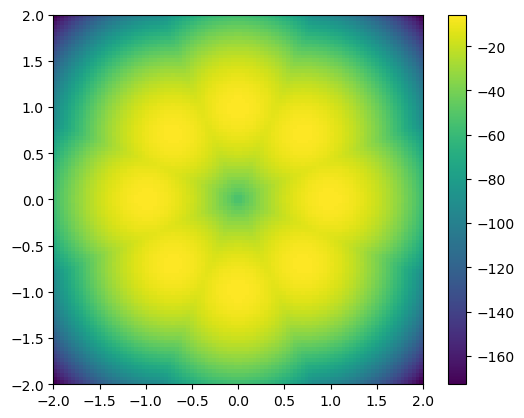

In [16]:
plt.imshow(log_prob_data, extent=[-2, 2, -2, 2])
plt.colorbar()

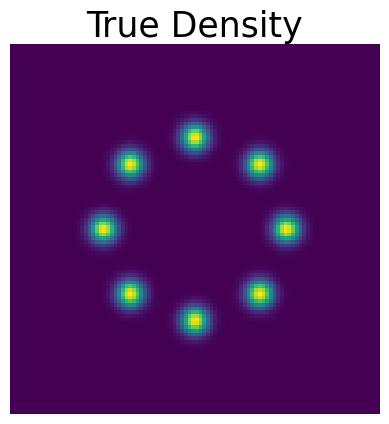

In [17]:
plt.imshow(torch.exp(log_prob_data), extent=[-2, 2, -2, 2])
plt.title('True Density',fontsize=25)
plt.axis('off')
plt.savefig('true_gaussian_mixture_density.pdf',bbox_inches='tight', pad_inches=0.01,dpi=300)

In [18]:
log_prob_forward = interpolant.log_prob(u).cpu().detach()
log_prob_forward=log_prob_forward-torch.logsumexp(log_prob_forward,dim=0).view(-1,1)
log_prob_forward=log_prob_forward.view(100,100)

In [19]:
log_prob_forward=log_prob_forward-torch.logsumexp(log_prob_forward, dim=(0, 1))
log_prob_data=log_prob_data-torch.logsumexp(log_prob_data, dim=(0, 1))


print(log_prob_forward.mean(),log_prob_data.mean())

kl=torch.sum(torch.exp(log_prob_data.view(-1,1))*(log_prob_data.view(-1,1)-log_prob_forward.view(-1,1)))
print(kl)

reverse_kl=torch.sum(torch.exp(log_prob_forward.view(-1,1))*(log_prob_forward.view(-1,1)-log_prob_data.view(-1,1)))
print(reverse_kl)

tensor(-34.0582) tensor(-40.7199)
tensor(0.0420)
tensor(0.0434)


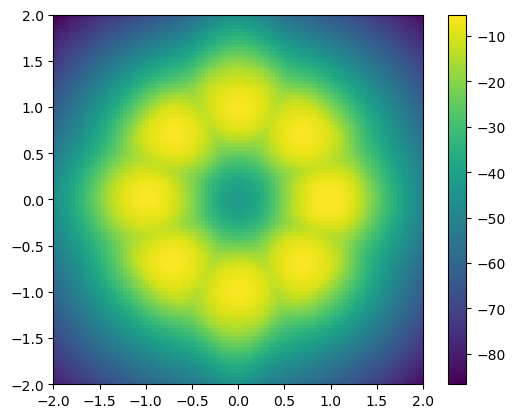

In [20]:
plt.imshow(log_prob_forward,extent=[-2, 2, -2, 2])
plt.colorbar()

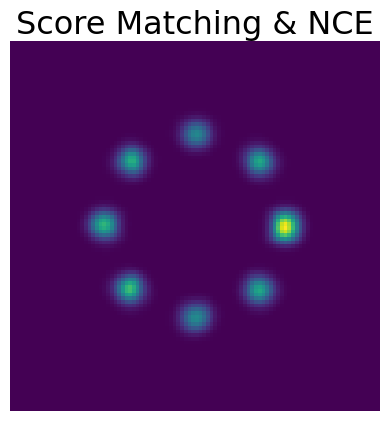

In [21]:
plt.imshow(torch.exp(log_prob_forward), extent=[-2, 2, -2, 2])
plt.axis('off')
if score_loss_multiplier>0 and nll_loss_multiplier>0:
    plt.title('Score Matching & NCE',fontsize=23)
elif score_loss_multiplier==0:
    plt.title('NCE',fontsize=25)
elif nll_loss_multiplier==0:
    plt.title('Score Matching',fontsize=254)
#plt.title('Predicted Density')
plt.savefig('predicted_gaussian_mixture_density_score_'+str(score_loss_multiplier)+'_nce_'+str(nll_loss_multiplier)+'.pdf',bbox_inches='tight', pad_inches=0.01,dpi=300)

In [22]:
data =  generate_checkerboard(n_samples=10000, xy_range=2.0, grid_width=0.4)
#data=generate_checkerboard(n_samples=10000)
interpolant = InterpolantModel(lr=1e-3,score_loss_multiplier=score_loss_multiplier,nll_loss_multiplier=nll_loss_multiplier,OT=False,integration_method='dopri5',interpolant_type='linear',antithetic=False)
data=data.cuda()
interpolant.model=interpolant.model.cuda()

In [23]:

posslosses=[]
ncelosses=[]
batch_size=10000
for epoch in tqdm.tqdm(range(10000)):
    for i in range(0,data.shape[0],batch_size):
        data_batch=data[i:i+batch_size]
        poss_loss,nce_loss=interpolant.train_step(data_batch, num_steps=1)
        posslosses.append(poss_loss)
        ncelosses.append(nce_loss)

100%|██████████| 10000/10000 [01:59<00:00, 83.82it/s]


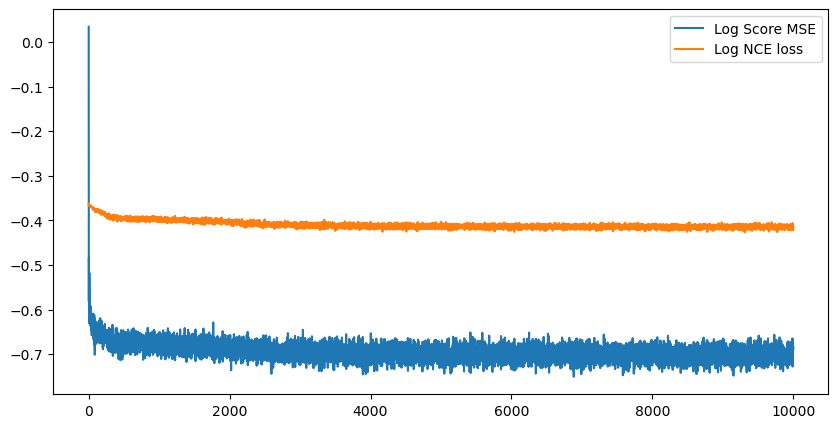

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(posslosses),label='Log Score MSE')
plt.plot(np.log(ncelosses),label='Log NCE loss')
plt.legend()

In [25]:
x = torch.linspace(-2,2,100).cuda()
u = torch.cartesian_prod(x, x.__reversed__()).cuda()

In [26]:
log_prob_data=checkerboard_logprob(u,2.0).cpu().detach()
log_prob_data=log_prob_data-torch.logsumexp(log_prob_data,dim=0).view(-1,1)
log_prob_data=log_prob_data.view(100,100)

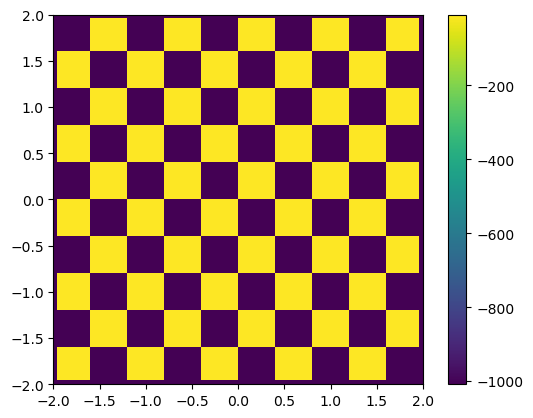

In [27]:
plt.imshow(log_prob_data, extent=[-2, 2, -2, 2])
plt.colorbar()

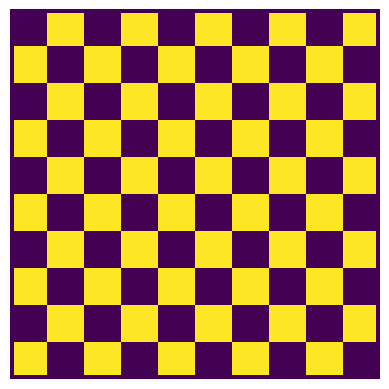

In [28]:
plt.imshow(torch.exp(log_prob_data), extent=[-2, 2, -2, 2])
#plt.title('True Density',fontsize=25)
plt.axis('off')
plt.savefig('true_checkerboard_density.pdf',bbox_inches='tight', pad_inches=0.01,dpi=300)

In [29]:
log_prob_forward = interpolant.log_prob(u).cpu().detach()
log_prob_forward=log_prob_forward-torch.logsumexp(log_prob_forward,dim=0).view(-1,1)
log_prob_forward=log_prob_forward.view(100,100)

In [30]:
log_prob_forward=log_prob_forward-torch.logsumexp(log_prob_forward, dim=(0, 1))
log_prob_data=log_prob_data-torch.logsumexp(log_prob_data, dim=(0, 1))


print(log_prob_forward.mean(),log_prob_data.mean())

kl=torch.sum(torch.exp(log_prob_data.view(-1,1))*(log_prob_data.view(-1,1)-log_prob_forward.view(-1,1)))
print(kl)

reverse_kl=torch.sum(torch.exp(log_prob_forward.view(-1,1))*(log_prob_forward.view(-1,1)-log_prob_data.view(-1,1)))
print(reverse_kl)

tensor(-11.4036) tensor(-528.2767)
tensor(0.2049)
tensor(78.8718)


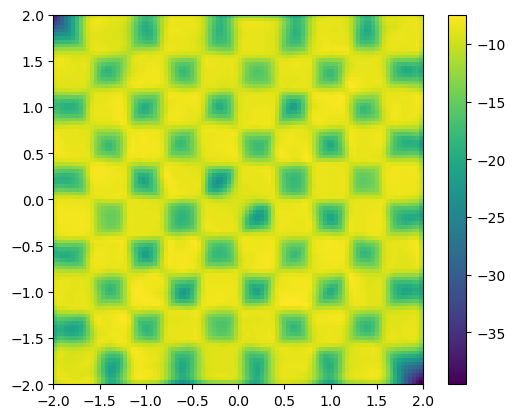

In [31]:
plt.imshow(log_prob_forward,extent=[-2, 2, -2, 2])
plt.colorbar()

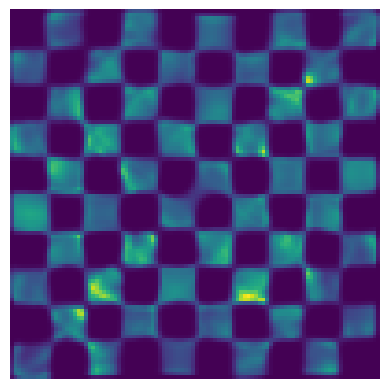

In [32]:
plt.imshow(torch.exp(log_prob_forward), extent=[-2, 2, -2, 2])
plt.axis('off')
# if score_loss_multiplier>0 and nll_loss_multiplier>0:
#     plt.title('Predicted Density - Score Matching and NCE')
# elif score_loss_multiplier==0:
#     plt.title('Predicted Density - NCE')
# elif nll_loss_multiplier==0:
#     plt.title('Predicted Density - Score Matching')
plt.savefig('predicted_checkerboard_mixture_density_score_'+str(score_loss_multiplier)+'_nce_'+str(nll_loss_multiplier)+'.pdf',bbox_inches='tight', pad_inches=0.01,dpi=300)